In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime
import re

# 正式分析

In [2]:
df = (
    pd.read_excel("zhihu-data.xlsx")
    .assign(
        修改动作全部 = lambda df:df['修改动作全部'].str.replace("\n",""),
        reason = lambda df:df['修改动作全部'].apply(lambda x:re.findall("理由：(.*?)#",x)).apply(lambda x: x[0] if len(x)>0 else np.NaN),
        date = lambda df:df['修改时间'].apply(lambda x: re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}',x)[0]),
        year = lambda df:df['date'].astype(str).apply(lambda x:re.findall('[0-9]{4}',x)[0]),
        month = lambda df:df['date'].astype(str).apply(lambda x:re.findall('[0-9]{4}-[0-9]{2}',x)[0]),
        页面词汇 = lambda df:df['页面词汇'].str.replace("\u200b",""),
        主题词 = lambda df:df['动作主题词'].str.replace('\u200b',""),
        修改动作的动作 = lambda df:df['修改动作'].apply(lambda x: x[:2]),
        修改动作的内容 = lambda df:df['修改动作'].apply(lambda x: x[3:]),
    )
    [['页面词汇', '主题词','动作主题词链接', 'year', 'date','month', '操作用户','修改动作的动作','修改动作的内容','删除字段', '增加字段','增减全部内容', 'reason']]
)

df.head()

页面词汇   主题词                               动作主题词链接  year        date  \
0  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2020  2020-01-21   
1  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2019  2019-02-26   
2  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30   
3  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30   
4  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30   

     month   操作用户 修改动作的动作 修改动作的内容      删除字段  增加字段    增减全部内容 reason  
0  2020-01     建花      移除    话题别名      女权主义   NaN      女权主义    NaN  
1  2019-02    张百忍      添加    话题别名       NaN  女权主义      女权主义    NaN  
2  2018-11  「已注销」      移除    话题别名      女权主义   NaN      女权主义    NaN  
3  2018-11  「已注销」      移除    话题别名        女权   NaN        女权    NaN  
4  2018-11  「已注销」      移除    话题别名  feminism   NaN  feminism    NaN

In [3]:
# len(df[df['主题词'].notnull()])

In [4]:
print("一共有{}条修改记录。".format(str(len(df))))

一共有3522条修改记录。


## 预设提问
（1） 有哪个词是来来回回被移出又添加到关系话题中的？（父话题、子话题）  
这些词儿，哪些是事件、哪些是概念  
是谁在修改，又是谁在修改类似的词儿  
（2） 有哪个词的内容被反复修改？（话题图片、话题描述、话题别名）

In [5]:
pd.set_option('display.max_rows', None)

### 对词条修改次数时间轴

In [6]:
# 补全日期
# 创建一个存有所有日期的dataframe

date_start = '2011-01-01'
date_end = '2020-02-01'

delta = datetime.datetime.strptime(date_end, '%Y-%m-%d') - datetime.datetime.strptime(date_start, '%Y-%m-%d')
date_list = []

for i in range(1, delta.days+1):
    date = (datetime.datetime.strptime(date_end, '%Y-%m-%d') - datetime.timedelta(days=i)).strftime('%Y-%m-%d')
    date_list.append(date)

# 用于补全日期的dataframe    
dateDF = (
    pd.DataFrame({'date':date_list})
    .assign(
        month = lambda df:df['date'].astype(str).apply(lambda x: re.match('[0-9]{4}-[0-9]{2}',x)[0])
    )
    [['month']]
    .drop_duplicates(keep='first')
)

In [7]:
dateDF.head()

month
0    2020-01
31   2019-12
62   2019-11
92   2019-10
123  2019-09

In [8]:
editTimes = (
    df['month'].value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
    .rename(columns={'index':'month', 'month':'counts'})
)

editTimesAll = (
    pd.merge(dateDF, editTimes, on='month', how='outer')
    .fillna(0)
    .sort_values(by='month', ascending=True)
)

# editTimesAll.to_clipboard(index = False)
editTimesAll.head()

month  counts
108  2011-01     1.0
107  2011-02     0.0
106  2011-03     0.0
105  2011-04     0.0
104  2011-05     1.0

In [9]:
# 查看修改次数最多的前五个月
# editTimes.sort_values(by='counts', ascending=False).head()

(-58.2, 500.0)

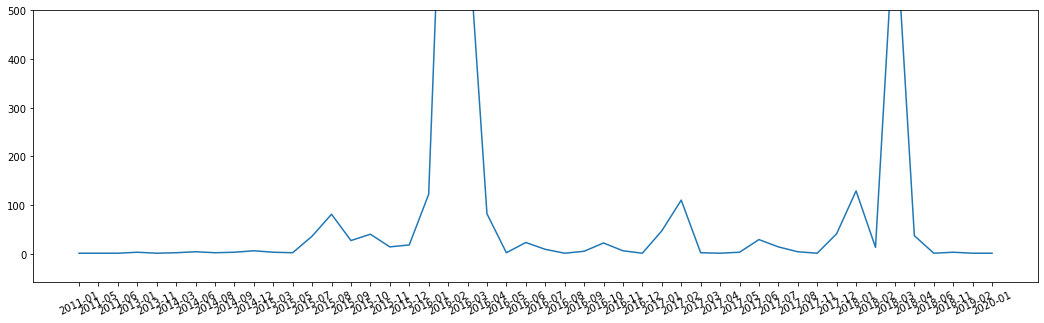

In [10]:
# 绘制草图
import matplotlib.pyplot as plt

# 调整图片尺寸
plt.rcParams["figure.figsize"] = (18,5)

plt.plot('month', 'counts', data = editTimes)
# rotate xticks
plt.xticks(rotation = 25)
# set the limit for y-axis
plt.ylim(top=500)

### 子话题的增减

In [11]:
# 3522条修改记录中，一共有多少是关于子话题的？
print("父话题和子话题的操作一共{}次。".format(str(len(df[df['修改动作的内容']=='父话题']))) )
# df.head()

父话题和子话题的操作一共3318次。


In [12]:
print("仅关于子话题的操作，就占到了{}次。".format(str(len(df[(df['修改动作的内容']=='父话题') & (df['主题词']!='女性主义')]))))

仅关于子话题的操作，就占到了2701次。


#### 详细记录版

In [13]:
# 调换父子话题顺序的function

def reverse_act(row):
    if row['页面词汇'] != row['主题词']:
        if row['修改动作的内容']=='父话题':
            return '子话题'
        elif row['修改动作的内容']=='子话题':
            return '父话题'
    elif row['页面词汇'] == row['主题词']:
        return row['修改动作的内容']
    else:
        return None
    
def find_actWord(row):
    if row['页面词汇'] == row['增减全部内容']:
        return row['主题词']
    elif row['页面词汇'] == row['主题词']:
        return row['增减全部内容']

In [14]:
topics_df = (
    df[df['修改动作的内容']=='父话题']
    .loc[
        lambda x:x['主题词'].notnull()
    ]
    .assign(
        修改动作的内容2 = lambda df:df.apply(reverse_act, axis=1),
        keyword2 = lambda df:df.apply(find_actWord, axis=1),
        dictKey = lambda df: df.index.astype(str) + df['操作用户'] + df['修改动作的动作'] + df['date'],
    )
    [['页面词汇', '操作用户', '修改动作的动作','dictKey','修改动作的内容2', 'keyword2', 'year','date','reason']]
    .assign(
        keyword2 = lambda df:df['keyword2'].apply(lambda x: re.sub('[(（].*?[）)]','',x))
    )
    .loc[
        lambda x:x['修改动作的内容2']=='子话题'
    ]
    .rename(columns={
        "keyword2":"动作关键词",
        "修改动作的动作":"修改动作",
        "修改动作的内容2":"修改条目",
        
    })
    .reset_index(drop=True)
)

In [15]:
# 为了保证同一天的“移除”和“添加”在一个正确的顺序
# 按照当天的顺序先给每个动作生成一个序号
topicsKeyword = topics_df['动作关键词'].unique().tolist()
topicsGroup1 = topics_df.groupby('动作关键词')

def makeActionDict(keyword):
    newdf = topicsGroup1.get_group(keyword).reset_index(drop=True)
    newdf['修改动作index'] = newdf.index.astype(str) + newdf['修改动作']
    ActionDict = dict(zip(newdf['dictKey'], newdf['修改动作index']))

    return ActionDict


def makeChangeDict(keyword):
    newdf = topicsGroup1.get_group(keyword).reset_index(drop=True)
    newdf['修改动作index'] = 'change' + newdf.index.astype(str)
    changeDict = dict(zip(newdf['dictKey'], newdf['修改动作index']))

    return changeDict

def mergeActionDict():
    ActionDict = {}
    changeDict = {}
    for keyword in topicsKeyword:
        keywordDict = makeActionDict(keyword)
        keywordDict2 = makeChangeDict(keyword)
        ActionDict.update(keywordDict)
        changeDict.update(keywordDict2)
        
    return ActionDict, changeDict
        
        
actionOrderDict, changeOrderDict = mergeActionDict()

# 再把这个序号带入原表中
topics_df = (
    topics_df
    .assign(
        修改动作label = lambda df:df['dictKey'].map(actionOrderDict),
        修改动作order = lambda df:df['dictKey'].map(changeOrderDict)
    )
)

topics_df.head(5)

页面词汇 操作用户 修改动作            dictKey 修改条目     动作关键词  year        date reason  \
0  女性主义  不谢邀   移除  14不谢邀移除2018-04-08  子话题       伪女权  2018  2018-04-08    NaN   
1  女性主义   旎旎   添加   15旎旎添加2018-04-08  子话题       伪女权  2018  2018-04-08    NaN   
2  女性主义  不谢邀   添加  16不谢邀添加2018-04-08  子话题    女性主义理论  2018  2018-04-08    NaN   
3  女性主义  不谢邀   移除  17不谢邀移除2018-04-08  子话题  女性主义电影理论  2018  2018-04-08    NaN   
4  女性主义  不谢邀   移除  18不谢邀移除2018-04-08  子话题    女性主义理论  2018  2018-04-08    NaN   

  修改动作label 修改动作order  
0       0移除   change0  
1       1添加   change1  
2       0添加   change0  
3       0移除   change0  
4       1移除   change1

In [16]:
# 子话题被修改的次数
nouns = topics_df['动作关键词'].value_counts().index.tolist()
nouns_counts = topics_df['动作关键词'].value_counts().tolist()
keyword_counts_dict = dict(zip(nouns, nouns_counts))


# 最终修改制图数据
topicsData = (
    topics_df
    .assign(
        修改总数 = lambda df:df['动作关键词'].map(keyword_counts_dict),
        month = lambda df:df['date'].astype(str).apply(lambda x: re.match('[0-9]{4}-[0-9]{2}',x)[0])
    )
    .sort_values(by=['修改总数','动作关键词','date','修改动作label'], ascending=[False, True, False,True])
    .rename(columns={
        '动作关键词':'keyword',
        '修改总数':'counts',
        '修改动作':'change',
        '操作用户':'user'
    })
    .reset_index(drop=True)
    [['keyword','counts','user','date','month','change','reason','修改动作order']]
)

# topicsData.to_csv("draft-data/01子话题修改记录.csv", encoding="utf-8", index=False)
topicsData.head()

keyword  counts user        date    month change reason 修改动作order
0    两性关系     189   海棠  2018-03-29  2018-03     移除    NaN   change0
1    两性关系     189  女木水  2018-03-29  2018-03     添加    NaN   change1
2    两性关系     189   树林  2018-03-23  2018-03     移除    NaN   change2
3    两性关系     189  女木水  2018-03-23  2018-03     添加    NaN   change3
4    两性关系     189  劳德诺  2018-01-28  2018-01     移除    NaN   change4

In [17]:
print("一共有{}个子话题。".format(len(topicsData['keyword'].unique())))
print("")
print("这些被不断修改的女性主义子话题包括：{}".format("，".join(topicsData['keyword'].unique())))

一共有107个子话题。

这些被不断修改的女性主义子话题包括：两性关系，家务劳动，避孕，女同性恋，生育，家庭，堕胎，产假，家庭暴力，性侵犯，单亲妈妈，割礼，性交易，物化，厌女症，生男生女，缠足，酷儿理论，女性贩运，性别差异，性别经济，男性主义，性别刻板印象，伪女权，性别气质，中国式伪女权，代孕，伪女权运动，公主病，厌男症，女权癌，Easy Girl，女德，女性安全，性别歧视，直女癌，逆向歧视，郭美美，妻子出轨，反女权主义，性别平等，拜金主义，消费主义，渣女，女权思潮，WePhone 创始人被逼身亡事件，吕雉，太平公主，希拉里邮件门、叛国案、克林顿基金会丑闻等系列事件，性别研究，江青，直男，绿茶婊，马蓉，人鬼情，后殖民女性主义，女性主义电影理论，女性权利运动，宋喆，性别文化，撒切尔夫人，政治正确，激进女性主义，父系制度，王宝强马蓉离婚事件，理工女，第二性，女性主义理论，Riot Grrrl，伊万卡·川普，克林顿拉链门，后现代女性主义，国民阵线，国际女性劳动节，女力主义，女性权利，女权即人权，女权天使，妇女史，妓女 ，婚姻，强奸，心理分析女性主义，性积极女性主义，性骚扰，拜金女郎，楼凤，欧洲难民危机，武则天，母系制度，泰勒·斯威夫特，洪秀柱，玛丽娜·勒庞，生态女性主义，男双性恋，男女平等，男权思维，社会主义女性主义，精神出轨，自以为是，英雌，金钱崇拜，高加索人至上主义，黑命贵，女性主义议题，女权主义者，女权运动


#### 每个子话题第一次出场的时间（DONE）

In [18]:
# keyword types dict

with open("pickles/typeDictsFinal.pickles","rb") as f:
    typeDict = pickle.load(f)

In [19]:
# load if_appearance dict

with open("pickles/ifAppearDict.pickles", "rb") as f:
    ifAppearDict = pickle.load(f)

In [20]:
topicsList = topicsData['keyword'].unique().tolist()
topicsGroup = topicsData.groupby('keyword')
firstAppRows = []

for item in topicsList:
    newdf = (
        topicsGroup.get_group(item)
        .sort_values(by='date', ascending=True)
    )
    
    firstApp = newdf[:1]
    firstAppRows.append(firstApp)
    
firstAppearanceDF = (
    pd.concat(firstAppRows)
    .assign(
        types = lambda df:df['keyword'].map(typeDict).str.replace("人事","具体人和事").str.replace("gender","性别话题相关"),
        ifAppear = lambda df:df['keyword'].map(ifAppearDict)
    )
    .reset_index(drop=True)
    [['keyword','types','counts','date','ifAppear']]
)

firstAppearanceDF

keyword   types  counts        date ifAppear
0                        两性关系   生育与生活     189  2015-07-13        Y
1                        家务劳动   生育与生活     162  2015-08-15        Y
2                          避孕   生育与生活     157  2015-08-15        Y
3                        女同性恋   具体人和事     149  2015-07-13        Y
4                          生育   生育与生活     149  2015-08-11        Y
5                          家庭   生育与生活     145  2015-08-13        Y
6                          堕胎   生育与生活     138  2015-08-11        Y
7                          产假   生育与生活     135  2015-07-13        Y
8                        家庭暴力   生育与生活     127  2015-07-13        Y
9                         性侵犯   生育与生活     120  2015-08-11        Y
10                       单亲妈妈   生育与生活     113  2016-02-13         
11                         割礼   生育与生活     109  2016-02-13         
12                        性交易   生育与生活     106  2015-08-11        Y
13                         物化    学术概念      63  2015-08-12         
14                        厌女症  性别话题相关      56  2015-07-14         
15                       生男生女   生育与生活      34  2015-09-07         
16                         缠足   生育与生活      34  2016-02-13         
17                       酷儿理论    学术概念      28  2015-08-12         
18                       女性贩运   生育与生活      26  2015-08-09         
19                       性别差异  性别话题相关      20  2015-07-13        Y
20                       性别经济  性别话题相关      20  2015-08-15         
21                       男性主义  性别话题相关      20  2015-07-13        Y
22                     性别刻板印象  性别话题相关      17  2015-07-13        Y
23                        伪女权    负面词汇      16  2016-11-12         
24                       性别气质  性别话题相关      16  2015-07-13        Y
25                     中国式伪女权    负面词汇      14  2018-01-30        Y
26                         代孕   生育与生活      14  2017-02-08        Y
27                      伪女权运动    负面词汇      14  2018-01-30         
28                        公主病    负面词汇      14  2018-02-10        Y
29                        厌男症  性别话题相关      14  2017-12-16         
30                        女权癌    负面词汇      14  2017-12-15        Y
31                  Easy Girl    负面词汇      12  2018-02-10         
32                         女德   生育与生活      12  2018-03-12         
33                       女性安全   生育与生活      12  2017-12-28         
34                       性别歧视  性别话题相关      12  2014-12-08        Y
35                        直女癌    负面词汇      12  2018-02-10        Y
36                       逆向歧视  性别话题相关      12  2018-03-12         
37                        郭美美   具体人和事      12  2018-03-12        Y
38                       妻子出轨   生育与生活      10  2018-02-15         
39                      反女权主义    负面词汇       9  2015-08-11         
40                       性别平等  性别话题相关       8  2014-12-08        Y
41                       拜金主义    负面词汇       8  2018-03-12         
42                       消费主义      其他       8  2018-03-12         
43                         渣女    负面词汇       8  2018-03-26         
44                       女权思潮    学术概念       7  2014-06-29         
45          WePhone 创始人被逼身亡事件   具体人和事       6  2018-03-12        Y
46                         吕雉   具体人和事       6  2018-03-23         
47                       太平公主   具体人和事       6  2018-03-23         
48   希拉里邮件门、叛国案、克林顿基金会丑闻等系列事件   具体人和事       6  2018-03-12         
49                       性别研究  性别话题相关       6  2015-07-13         
50                         江青   具体人和事       6  2018-03-23         
51                         直男  性别话题相关       6  2016-12-06         
52                        绿茶婊    负面词汇       6  2018-03-26        Y
53                         马蓉   具体人和事       6  2018-03-12        Y
54                        人鬼情      其他       4  2018-03-05         
55                    后殖民女性主义    学术概念       4  2017-07-24         
56                   女性主义电影理论    学术概念       4  2015-08-10         
57                     女性权利运动    学术概念       4  2016-11-10         
58                         宋喆   具体人和事       4  2018-03-26         
59

In [21]:
firstAppearanceDF['types'].unique()

array(['生育与生活', '具体人和事', '学术概念', '性别话题相关', '负面词汇', '其他'], dtype=object)

但因为实在是太多子话题了，所以……  
#### 概括统计版

In [22]:
# 判断这个子话题是否最终成为了子话题
topicsKeyword = topics_df['动作关键词'].unique().tolist()
topicsGroup1 = topics_df.groupby('动作关键词')


def decideIfChild(keyword):
    newdf = topicsGroup1.get_group(keyword).reset_index(drop=True)[:1]
    if newdf['修改动作'][0] == '移除':
        return "N"
    elif newdf['修改动作'][0] == '添加':
        return "Y"
    
    
def makeChildDict():
    childDict = {}
    for keyword in topicsKeyword:
        childResult = decideIfChild(keyword)
        childDict[keyword] = childResult
        
    return childDict
    
childDict = makeChildDict()

In [25]:
# # # 给每个词一个性质
# # # 手动
# # with open("pickles/topicTypeDict.pickle","rb") as f:
# #     topicTypeDict = pickle.load(f)
    
# # 给每个词一个性质
# # 手动 
# # life and people
# # gender
# # descrimination
# # with open("pickles/topicTypeDict_lifeandpeople.pickle","rb") as f:
# #     topicTypeDict2 = pickle.load(f)

# topicsLP = (
#     topicsData.groupby(['keyword','month']).size().reset_index()
#     .assign(
#         修改总数 = lambda df:df['keyword'].map(keyword_counts_dict),
#         ifChild = lambda df:df['keyword'].map(childDict),
# #         types = lambda df:df['keyword'].map(topicTypeDict2)
#     )
# #     .loc[
# #         lambda x:x['types']!="" # 删掉没有性质的词。。。江青
# #     ]
#     .rename(columns={0:'counts'})
#     .sort_values(by=['修改总数','keyword','month'],ascending=[False,True,True])
#     .reset_index(drop=True)
#     [['keyword','month','counts','ifChild','types']]
# )

# topicsLP.head()

In [26]:
# # 生成Type数量的映射字典
# typesOrder = (
#     topicsLP['types'].value_counts().reset_index()
#     .assign(
#         order = lambda df:df.index,
#     )
# )

# typesOrderDict = dict(zip(typesOrder['index'], typesOrder['order']))
# # typesOrderDict

In [27]:
# topicsLP_ordered = (
#     topicsLP.groupby(['keyword','types','ifChild'])['counts'].sum().reset_index()
#     .assign(
#         order = lambda df:df['types'].map(typesOrderDict),
#         types = lambda df:df['types'].str.replace("人事","具体人和事")
#     )
# #     .sort_values(by=['order','counts'], ascending=[True, False])
#     .sort_values(by=['counts'], ascending=False)
#     [['keyword','types','counts','ifChild']]
#     .reset_index(drop=True)
# )

# # topicsLP_ordered.to_csv("draft-data/子话题修改记录_lifeandpeole.csv", encoding="utf-8", index=False)
# topicsLP_ordered
# print("共{}条词语和 Life and people 有关".format(len(topicsLP_ordered[topicsLP_ordered['types'].str.contains("|".join(["生育与生活","具体人和事"]))])))
# print("共{}条词语和 gender 有关".format(len(topicsLP_ordered[topicsLP_ordered['types']=='gender'])))
# print("共{}条词语和 负面词汇 有关".format(len(topicsLP_ordered[topicsLP_ordered['types']=='负面词汇'])))

In [82]:
# 过滤出相关type的词汇
# 替换关键词使用的 function

def getTopicsDF(keyword):
    topicsDF = topicsLP_ordered[topicsLP_ordered['types']==keyword].reset_index(drop=True)
    return topicsDF

keyword = "负面词汇"
topicsResult = getTopicsDF(keyword)
# topicsResult.to_clipboard(index=False)

In [83]:
# # 草图想法V2生成
# # 把每个词组的日期都补全

# topicsGroup2 = topicsDF.groupby('keyword')
# topicsFullDatesList = []

# for keyword in topicsKeyword:
#     newdf = topicsGroup2.get_group(keyword)
#     newdfMerge = (
#         pd.merge(newdf, dateDF, on='month', how='outer')
#         .assign(
#             keyword = lambda df:df['keyword'].apply(lambda x:keyword if pd.isnull(x) else x),
#             counts = lambda df:df['counts'].apply(lambda x: 0 if pd.isnull(x) else x),
#             ifChild = lambda df:df['keyword'].map(childDict),
#         )
#         .sort_values(by=['month'], ascending=[True])
#         [['keyword','month','counts','ifChild']]
#     )
    
#     topicsFullDatesList.append(newdfMerge)

# topicDF = (
#     pd.concat(topicsFullDatesList)
#     .assign(
#         修改总数 = lambda df:df['keyword'].map(keyword_counts_dict),
#     )
#     .sort_values(by=['修改总数','keyword','month'],ascending=[False,True,True])
#     .reset_index(drop=True)
#     [['keyword','month','counts','ifChild']]
# )


# # topicDF.to_csv("draft-data/02子话题修改记录.csv", encoding="utf-8", index=False)
# topicDF.head(10)

In [85]:
# print("最终成为子话题只有 {}。".format("，".join(topicDF[topicDF['ifChild']=='Y']['keyword'].unique().tolist())))
# print("")
# print("这就让我开始思考另一个问题，为什么大佬们要疯狂删除和增加这些子话题。")

#### 修改次数超过100次的关键词（DONE）

In [28]:
# 找出原表格中带有修改时间的维度

topTenTopicsDF = (
    topicsData.groupby(['keyword','month']).size().reset_index()
    .assign(
        修改总数 = lambda df:df['keyword'].map(keyword_counts_dict),
        ifChild = lambda df:df['keyword'].map(childDict),
    )
    .loc[
        lambda x:x['修改总数'] >= 100
    ]
    .rename(columns={0:'counts'})
    .sort_values(by=['修改总数','keyword','month'],ascending=[False,True,True])
    .reset_index(drop=True)
    [['keyword','month','counts','ifChild']]
)

# topTenTopicsDF
print("修改次数超过百次的关键词有{}。".format("、".join(topTenTopicsDF['keyword'].unique().tolist())))

修改次数超过百次的关键词有两性关系、家务劳动、避孕、女同性恋、生育、家庭、堕胎、产假、家庭暴力、性侵犯、单亲妈妈、割礼、性交易。


In [33]:
# 补全日期
# 创建一个存有所有日期的dataframe

date_start = '2015-01-01'
date_end = '2018-12-31'

delta = datetime.datetime.strptime(date_end, '%Y-%m-%d') - datetime.datetime.strptime(date_start, '%Y-%m-%d')
date_list = []

for i in range(1, delta.days+1):
    date = (datetime.datetime.strptime(date_end, '%Y-%m-%d') - datetime.timedelta(days=i)).strftime('%Y-%m-%d')
    date_list.append(date)

# 用于补全日期的dataframe    
dateDF = (
    pd.DataFrame({'date':date_list})
    .assign(
        month = lambda df:df['date'].astype(str).apply(lambda x: re.match('[0-9]{4}-[0-9]{2}',x)[0])
    )
    [['month']]
    .drop_duplicates(keep='first')
)

In [34]:
topTenTopicsDF.head()

keyword    month  counts ifChild
0    两性关系  2015-07       9       N
1    两性关系  2015-08       8       N
2    两性关系  2015-09       2       N
3    两性关系  2015-10       5       N
4    两性关系  2015-11       4       N

In [36]:
# 绘制每个
topTopicGroups = topTenTopicsDF.groupby('keyword')
topicsKeyword = topTenTopicsDF['keyword'].unique().tolist()
topicsFullDatesList = []

for keyword in topicsKeyword:
    newdf = topTopicGroups.get_group(keyword)
    newdfMerge = (
        pd.merge(newdf, dateDF, on='month', how='outer')
        .assign(
            keyword = lambda df:df['keyword'].apply(lambda x:keyword if pd.isnull(x) else x),
            counts = lambda df:df['counts'].apply(lambda x: 0 if pd.isnull(x) else x),
            ifChild = lambda df:df['keyword'].map(childDict),
        )
        .sort_values(by=['month'], ascending=[True])
        [['keyword','month','counts','ifChild']]
    )
    
    topicsFullDatesList.append(newdfMerge)

topTenTopicsDates = (
    pd.concat(topicsFullDatesList)
    .assign(
        修改总数 = lambda df:df['keyword'].map(keyword_counts_dict),
    )
    .sort_values(by=['修改总数','keyword','month'],ascending=[False,True,True])
    .reset_index(drop=True)
    .assign(
        counts = lambda df:df['counts'].fillna(0).astype(int)
    )
    [['keyword','month','counts','ifChild','修改总数']]
)

topTenTopicsDates.head()

keyword    month  counts ifChild  修改总数
0    两性关系  2015-01       0       N   189
1    两性关系  2015-02       0       N   189
2    两性关系  2015-03       0       N   189
3    两性关系  2015-04       0       N   189
4    两性关系  2015-05       0       N   189

In [37]:
# topTenTopicsDates.to_clipboard(index=False)

In [121]:
# 一键存到xampp
# topTenTopicsDates.to_csv("F:/xampp/htdocs/multiple-line-chart/data/topTopics2.csv", index=False)

### 子话题增减的原因（DONE）

In [43]:
# 操作的理由，editor's pick存档
with open("pickles/reasonsDict.pickle","rb") as f:
    reasonsDict = pickle.load(f)

In [49]:
topics_df.head()

页面词汇 操作用户 修改动作            dictKey 修改条目     动作关键词  year        date reason  \
0  女性主义  不谢邀   移除  14不谢邀移除2018-04-08  子话题       伪女权  2018  2018-04-08    NaN   
1  女性主义   旎旎   添加   15旎旎添加2018-04-08  子话题       伪女权  2018  2018-04-08    NaN   
2  女性主义  不谢邀   添加  16不谢邀添加2018-04-08  子话题    女性主义理论  2018  2018-04-08    NaN   
3  女性主义  不谢邀   移除  17不谢邀移除2018-04-08  子话题  女性主义电影理论  2018  2018-04-08    NaN   
4  女性主义  不谢邀   移除  18不谢邀移除2018-04-08  子话题    女性主义理论  2018  2018-04-08    NaN   

  修改动作label 修改动作order  
0       0移除   change0  
1       1添加   change1  
2       0添加   change0  
3       0移除   change0  
4       1移除   change1

In [52]:
topics_df.drop_duplicates(subset=['修改动作','reason'], keep='first')

页面词汇    操作用户 修改动作                dictKey 修改条目    动作关键词  year  \
0     女性主义     不谢邀   移除      14不谢邀移除2018-04-08  子话题      伪女权  2018   
1     女性主义      旎旎   添加       15旎旎添加2018-04-08  子话题      伪女权  2018   
476   女性主义     不谢邀   添加     772不谢邀添加2018-01-17  子话题   性别刻板印象  2018   
494   女性主义     女木水   添加     816女木水添加2018-01-12  子话题       代孕  2018   
529   女性主义     女木水   添加     871女木水添加2018-01-06  子话题   性别刻板印象  2018   
533   女性主义     女木水   移除     879女木水移除2018-01-06  子话题  后殖民女性主义  2018   
543   女性主义     不谢邀   添加     898不谢邀添加2017-12-28  子话题      性侵犯  2017   
549   女性主义     不谢邀   添加     910不谢邀添加2017-12-24  子话题     女同性恋  2017   
550   女性主义  Amadnn   移除  911Amadnn移除2017-12-21  子话题     女同性恋  2017   
552   女性主义     王德彪   添加     913王德彪添加2017-12-20  子话题     政治正确  2017   
585   女性主义    风葬秋冥   添加    966风葬秋冥添加2017-06-14  子话题      性侵犯  2017   
697   女性主义      张伟   添加     1147张伟添加2016-11-02  子话题     性别平等  2016   
721   女性主义     女木水   添加    1176女木水添加2016-08-01  子话题     两性关系  2016   
739   女性主义     女木水   添加    1196女木水添加2016-06-25  子话题     女同性恋  2016   
749   女性主义     女木水   添加    1211女木水添加2016-04-30  子话题     酷儿理论  2016   
1448  女性主义     女木水   添加    2120女木水添加2016-02-26  子话题       生育  2016   
2006  女性主义     女木水   添加    2787女木水添加2016-02-14  子话题       家庭  2016   
2370  女性主义     女木水   添加    3237女木水添加2016-01-14  子话题       生育  2016   
2371  女性主义     女木水   添加    3239女木水添加2016-01-14  子话题       家庭  2016   
2372  女性主义     女木水   添加    3240女木水添加2016-01-14  子话题     家务劳动  2016   
2373  女性主义     女木水   添加    3241女木水添加2016-01-14  子话题     两性关系  2016   
2378  女性主义     女木水   添加    3249女木水添加2016-01-12  子话题       家庭  2016   
2379  女性主义     女木水   添加    3252女木水添加2016-01-12  子话题     家务劳动  2016   
2381  女性主义     女木水   添加    3254女木水添加2016-01-12  子话题       避孕  2016   
2383  女性主义     女木水   添加    3256女木水添加2016-01-12  子话题     两性关系  2016   
2384  女性主义      陈醉   移除     3258陈醉移除2016-01-03  子话题       家庭  2016   
2385  女性主义      陈醉   移除     3259陈醉移除2016-01-03  子话题       避孕  2016   
2386  女性主义      陈醉   移除     3260陈醉移除2016-01-03  子话题     家务劳动  2016   
2388  女性主义     女木水   添加    3266女木水添加2016-01-03  子话题     家务劳动  2016   
2389  女性主义     女木水   添加    3267女木水添加2016-01-03  子话题       家庭  2016   
2390  女性主义     女木水   添加    3268女木水添加2016-01-03  子话题       避孕  2016   
2391  女性主义   Casey   移除  3269Casey移除2016-01-02  子话题       避孕  2016   
2392  女性主义   Casey   移除  3270Casey移除2016-01-02  子话题       家庭  2016   
2405  女性主义     女木水   添加    3283女木水添加2015-12-23  子话题     两性关系  2015   
2408  女性主义     女木水   添加    3287女木水添加2015-12-14  子话题     女同性恋  2015   
2422  女性主义     女木水   添加    3306女木水添加2015-11-04  子话题       家庭  2015   
2451  女性主义      陈醉   添加     3340陈醉添加2015-10-08  子话题      厌女症  2015   
2455  女性主义     女木水   添加    3346女木水添加2015-10-03  子话题     家务劳动  2015   
2457  女性主义     女木水   添加    3352女木水添加2015-09-08  子话题       家庭  2015   
2458  女性主义     女木水   添加    3353女木水添加2015-09-07  子话题       堕胎  2015   
2459  女性主义     女木水   添加    3355女木水添加2015-09-07  子话题       生育  2015   
2460  女性主义     女木水   添加    3356女木水添加2015-09-07  子话题       避孕  2015   
2461  女性主义     女木水   添加    3358女木水添加2015-09-07  子话题     女同性恋  2015   
2470  女性主义     女木水   添加    3372女木水添加2015-09-05  子话题     两性关系  2015   
2471  女性主义     女木水   添加    3373女木水添加2015-09-05  子话题      性交易  2015   
2474  女性主义     女木水   添加    3376女木水添加2015-08-30  子话题     两性关系  2015   
2490  女性主义     女木水   添加    3409女木水添加2015-08-12  子话题     两性关系  2015   
2536  女性主义     女木水   添加    3465女木水添加2015-07-14  子话题     两性关系  2015   

            date                                             reason 修改动作label  \
0     2018-04-08                                                NaN       0移除   
1     2018-04-08                                                NaN       1添加   
476   2018-01-17                                       代表公共编辑规范撤销你。       8添加   
494   2018-01-12                                               恶意编辑       7添加   
529   2018-01-06                                               分类错误      10添加   
533   2018-01-06                                               分类错误       0移除   
543   20

In [55]:
df.sort_values(by='date', ascending=True)

页面词汇                           主题词  \
3521  女性主义                          女性主义   
3520  女性主义                          女性主义   
3519  女性主义                          女性主义   
3518  女性主义                          女性主义   
3516  女性主义                          女性主义   
3517  女性主义                          女性主义   
3515  女性主义                          女性主义   
3514  女性主义                          女性主义   
3513  女性主义                          女性主义   
3512  女性主义                          女性主义   
3511  女性主义                          女权思潮   
3510  女性主义                          女性主义   
3509  女性主义                          男女平等   
3508  女性主义                          女性主义   
3507  女性主义                          女性主义   
3506  女性主义                          女性主义   
3504  女性主义                          男女平等   
3505  女性主义                          女性主义   
3503  女性主义                          女性主义   
3502  女性主义                          性别平等   
3501  女性主义                          性别歧视   
3500  女性主义                    父系制度（社会制度）   
3499  女性主义                          男权思维   
3498  女性主义                          女性主义   
3497  女性主义                          女性主义   
3496  女性主义                          女性主义   
3495  女性主义                          女性主义   
3494  女性主义                           NaN   
3493  女性主义                           NaN   
3491  女性主义                          女性主义   
3474  女性主义                          女性主义   
3475  女性主义                          两性关系   
3476  女性主义                          女性主义   
3477  女性主义                          女同性恋   
3478  女性主义                            强奸   
3479  女性主义                           性骚扰   
3480  女性主义                            产假   
3492  女性主义                          女性主义   
3481  女性主义                          家庭暴力   
3483  女性主义                          男性主义   
3484  女性主义                        性别刻板印象   
3485  女性主义                          性别文化   
3486  女性主义                          性别差异   
3487  女性主义                          性别气质   
3488  女性主义                          性别研究   
3489  女性主义                          女权思潮   
3490  女性主义                          女性主义   
3482  女性主义                          女性主义   
3468  女性主义                          女性主义   
3467  女性主义                          女性主义   
3469  女性主义                          女性主义   
3465  女性主义                          两性关系   
3471  女性主义                          女性主义   
3470  女性主义                          女性主义   
3473  女性主义                           厌女症   
3466  女性主义                          女性主义   
3472  女性主义                          两性关系   
3464  女性主义                          两性关系   
3463  女性主义                          两性关系   
3462  女性主义                          两性关系   
3461  女性主义                          两性关系   
3460  女性主义                          女性主义   
3459  女性主义                          女性主义   
3458  女性主义                          两性关系   
3457  女性主义                          两性关系   
3440  女性主义                          性别气质   
3442  女性主义                    母系制度（社会制度）   
3443  女性主义                          女同性恋   
3444  女性主义                          性别歧视   
3445  女性主义                          女性主义   
3446  女性主义                          性别研究   
3447  女性主义                          性别差异   
3441  女性主义                    父系制度（社会制度）   
3449  女性主义                          性别歧视   
3450  女性主义                    父系制度（社会制度）   
3451  女性主义                          男权思维   
3452  女性主义                          两性关系   
3453  女性主义                           性骚扰   
3454  女性主义                          女性主义   
3455  女性主义                          性别平等   
3456  女性主义                          男性主义   
3448  女性主义                          女性主义   
3439  女性主义                        女性主义理论   
3437  女性主义                        激进女性主义   
3438  女性主义                        激进女性主义   
3428  女性主义                          两性关系   
3429  女性主义                          性别平等   
3431  女性主义                          女同性恋   
3430  女性主义                          女性主义   
3433  女性主义                    父系制度（社会制度）   
34

In [71]:
reasons_df = (
    topics_df
    [['页面词汇','操作用户','修改动作','修改条目','动作关键词','date','reason']]
    .loc[
        lambda x:x['reason'].notnull() #不保留没有写任何理由的操作
    ]
)

reasons_count = (
    reasons_df.groupby(['修改动作','动作关键词']).size().reset_index().rename(columns={0:'counts'})
    .sort_values(by='counts', ascending=False)
    .assign(
        keys = lambda df:df['修改动作'] + df['动作关键词'],
        reason = lambda df:df['keys'].map(reasonsDict)
    )
    .loc[
        lambda x:x['reason'].notnull()
    ]
    .reset_index(drop=True)
    .drop(columns=['keys'])
)

reasons_count.to_clipboard(index=False)
reasons_count

修改动作 动作关键词  counts                                             reason
0   添加  两性关系      92  性别在人类的社会生活中是最重要的分类之一，在上个世纪里，人们关于性别的看法和信念发生了革命性...
1   添加  家务劳动      79                    家务劳动是女权主义的重要主题，是公私两分制社会体系重要的论点。
2   添加    避孕      74  避孕的发明是女权的基石，女权主义公开讨论性的非繁殖功能，就像是开了一道泄洪阀，开启了关于性的论战。
3   添加    家庭      74  弗里德里希·冯·恩格斯（Friedrich VonEngels）的《家庭、私有制和国家的起源...
4   添加  女同性恋      69  1970年代，受第二波女性主义（Second-wave feminism）运动影响，该术语开...
5   添加    堕胎      64                                  堕胎权是女性主义的重要政治诉求之一
6   添加  酷儿理论       9                                        酷儿理论脱胎于女权主义
7   移除    避孕       2  这种标签会使诸如哪种避孕套用户体验最佳这样的问题一直活跃在话题之下，而关注女性主义话题的人并...
8   移除  家务劳动       1  这种标签会使诸如应该买什么样的洗碗机这样的问题一直活跃在话题之下，而关注女性主义话题的人并不...

## 话题语义的改变

In [123]:
define_list = ['话题别名','话题描述','话题名称']
define_counts = [134, 54, 11]
define_dict = dict(zip(define_list, define_counts))

define_df = (
    df[df['修改动作的内容'].str.contains("|".join(define_list))]
    [['主题词','date','操作用户','修改动作的动作','修改动作的内容','删除字段','增加字段','reason']]
    .assign(
        counts = lambda df:df['修改动作的内容'].map(define_dict)
    )
    .sort_values(by=['counts','date'], ascending=[False, True])
    .drop(columns=['counts'])
)

define_df

主题词        date              操作用户 修改动作的动作 修改动作的内容  \
3518  女性主义  2013-01-18                李奇      添加    话题别名   
3516  女性主义  2013-01-25             psjay      添加    话题别名   
3517  女性主义  2013-01-25             psjay      移除    话题别名   
3513  女性主义  2014-03-18        Alex Huang      添加    话题别名   
3482  女性主义  2015-07-13               女木水      添加    话题别名   
3417  女性主义  2015-08-11               女木水      添加    话题别名   
3408  女性主义  2015-08-12               张小平      添加    话题别名   
3403  女性主义  2015-08-13               女木水      添加    话题别名   
3404  女性主义  2015-08-13               女木水      移除    话题别名   
3395  女性主义  2015-08-14               女木水      添加    话题别名   
3396  女性主义  2015-08-14               女木水      添加    话题别名   
3397  女性主义  2015-08-14               女木水      添加    话题别名   
3398  女性主义  2015-08-14               女木水      添加    话题别名   
3399  女性主义  2015-08-14               女木水      移除    话题别名   
3400  女性主义  2015-08-14               女木水      添加    话题别名   
3401  女性主义  2015-08-14               女木水      移除    话题别名   
3402  女性主义  2015-08-14               女木水      移除    话题别名   
3385  女性主义  2015-08-18               女木水      添加    话题别名   
3382  女性主义  2015-08-19               女木水      添加    话题别名   
3379  女性主义  2015-08-23               女木水      添加    话题别名   
3380  女性主义  2015-08-23               女木水      添加    话题别名   
1108  女性主义  2017-01-11        海棠 Fuchsia      移除    话题别名   
1109  女性主义  2017-01-11        海棠 Fuchsia      移除    话题别名   
1117  女性主义  2017-01-11        海棠 Fuchsia      移除    话题别名   
1092  女性主义  2017-02-02               杨则非      移除    话题别名   
1093  女性主义  2017-02-02               杨则非      移除    话题别名   
1049  女性主义  2017-02-09               女木水      添加    话题别名   
1050  女性主义  2017-02-09               女木水      添加    话题别名   
1069  女性主义  2017-02-09               女木水      添加    话题别名   
1076  女性主义  2017-02-09               女木水      添加    话题别名   
1077  女性主义  2017-02-09               女木水      添加    话题别名   
1026  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1027  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1028  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1029  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1030  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1031  女性主义  2017-02-16        海棠 Fuchsia      移除    话题别名   
1000  女性主义  2017-02-17               女木水      添加    话题别名   
1001  女性主义  2017-02-17               女木水      添加    话题别名   
1002  女性主义  2017-02-17               女木水      添加    话题别名   
1003  女性主义  2017-02-17               女木水      添加    话题别名   
1004  女性主义  2017-02-17               女木水      添加    话题别名   
1005  女性主义  2017-02-17               女木水      添加    话题别名   
904   女性主义  2017-12-27             aa aa      移除    话题别名   
905   女性主义  2017-12-27             aa aa      移除    话题别名   
895   女性主义  2017-12-28              主机侦探      移除    话题别名   
896   女性主义  2017-12-28              主机侦探      移除    话题别名   
900   女性主义  2017-12-28               不谢邀      添加    话题别名   
901   女性主义  2017-12-28               不谢邀      添加    话题别名   
882   女性主义  2018-01-06               女木水      添加    话题别名   
883   女性主义  2018-01-06               女木水      添加    话题别名   
843   女性主义  2018-01-09                林飞      移除    话题别名   
844   女性主义  2018-01-09                林飞      移除    话题别名   
845   女性主义  2018-01-09                林飞      移除    话题别名   
842   女性主义  2018-01-10                林飞      添加    话题别名   
838   女性主义  2018-01-12               女木水      添加    话题别名   
839   女性主义  2018-01-12               女木水      添加    话题别名   
840   女性主义  2018-01-12               女木水      添加    话题别名   
841   女性主义  2018-01-12               女木水      移除    话题别名   
786   女性主义  2018-01-17               不谢邀      添加    话题别名   
787   女性主义  2018-01-17               不谢邀      添加    话题别名   
790   女性主义  2018-01-17               不谢邀      添加    话题别名   
791   女性主义  2018-01-17           衣食父母教育你      移除    话题别名   
793   女性主义  2018-01-17           衣食父母教育你      添加    话题别名   
795   女性主义  2018-01-17           衣食父母教育你      移除    话题别名   
796   女性主义  2018-01-17           衣食父母教育你      移

In [124]:
define_df[define_df['修改动作的内容']=='话题描述']

主题词        date              操作用户 修改动作的动作 修改动作的内容  \
3505  女性主义  2014-09-25             Marzo      编辑    话题描述   
3476  女性主义  2015-07-13               女木水      编辑    话题描述   
3492  女性主义  2015-07-13               女木水      编辑    话题描述   
3460  女性主义  2015-07-19               女木水      编辑    话题描述   
978   女性主义  2017-06-02  Shinogei Shinsui      编辑    话题描述   
975   女性主义  2017-06-05       Blank Image      编辑    话题描述   
948   女性主义  2017-07-08               易建联      编辑    话题描述   
946   女性主义  2017-07-27             养过几天猫      编辑    话题描述   
944   女性主义  2017-07-28               女木水      编辑    话题描述   
945   女性主义  2017-07-28               女木水      编辑    话题描述   
932   女性主义  2017-08-06             养过几天猫      编辑    话题描述   
931   女性主义  2017-11-17           幻想乡的观测者      编辑    话题描述   
930   女性主义  2017-12-07              凤山脚下      编辑    话题描述   
926   女性主义  2017-12-12                逼蒙      编辑    话题描述   
815   女性主义  2018-01-12               女木水      编辑    话题描述   
770   女性主义  2018-01-17               女木水      编辑    话题描述   
788   女性主义  2018-01-17               不谢邀      编辑    话题描述   
794   女性主义  2018-01-17           衣食父母教育你      编辑    话题描述   
813   女性主义  2018-01-17           衣食父母教育你      编辑    话题描述   
726   女性主义  2018-03-12        海棠 Fuchsia      编辑    话题描述   
727   女性主义  2018-03-12        海棠 Fuchsia      编辑    话题描述   
728   女性主义  2018-03-12        海棠 Fuchsia      编辑    话题描述   
487   女性主义  2018-03-23                海棠      编辑    话题描述   
346   女性主义  2018-03-26                海棠      编辑    话题描述   
390   女性主义  2018-03-26                海棠      编辑    话题描述   
394   女性主义  2018-03-26                海棠      编辑    话题描述   
395   女性主义  2018-03-26                海棠      编辑    话题描述   
396   女性主义  2018-03-26                海棠      编辑    话题描述   
438   女性主义  2018-03-26               女木水      编辑    话题描述   
439   女性主义  2018-03-26               女木水      编辑    话题描述   
440   女性主义  2018-03-26                海棠      编辑    话题描述   
459   女性主义  2018-03-26                海棠      编辑    话题描述   
323   女性主义  2018-03-27                海棠      编辑    话题描述   
327   女性主义  2018-03-27                海棠      编辑    话题描述   
333   女性主义  2018-03-27                树林      编辑    话题描述   
334   女性主义  2018-03-27                树林      编辑    话题描述   
273   女性主义  2018-03-28                树林      编辑    话题描述   
311   女性主义  2018-03-28               女木水      编辑    话题描述   
312   女性主义  2018-03-28               女木水      编辑    话题描述   
51    女性主义  2018-03-29                刘柯      编辑    话题描述   
93    女性主义  2018-03-29                海棠      编辑    话题描述   
97    女性主义  2018-03-29                海棠      编辑    话题描述   
128   女性主义  2018-03-29               女木水      编辑    话题描述   
130   女性主义  2018-03-29                海棠      编辑    话题描述   
175   女性主义  2018-03-29               女木水      编辑    话题描述   
176   女性主义  2018-03-29                海棠      编辑    话题描述   
177   女性主义  2018-03-29               女木水      编辑    话题描述   
178   女性主义  2018-03-29                海棠      编辑    话题描述   
181   女性主义  2018-03-29               女木水      编辑    话题描述   
183   女性主义  2018-03-29                海棠      编辑    话题描述   
194   女性主义  2018-03-29               女木水      编辑    话题描述   
237   女性主义  2018-03-29                海棠      编辑    话题描述   
240   女性主义  2018-03-29               女木水      编辑    话题描述   
5     女性主义  2018-06-26             Simon      编辑    话题描述   

                                                   删除字段  \
3505                                                NaN   
3476                                                NaN   
3492          运动、,要以女,经验为来源与动机,。在对社会关系进行,，许多女性主义的支持者,妇女   
3460            历史上，女权运动和同性恋权利运动一直摩擦多,合作，二者的交集基,局限,女同性恋   
978                                                 NaN   
975                                                 NaN   
948                                                 NaN   
946                                         、妇女解放（女性解放）   
944                                                 NaN   
945                                                 NaN   
932                                                 NaN  

In [20]:
define_df.columns

Index(['主题词', 'date', '操作用户', '修改动作的动作', '修改动作的内容', '删除字段', '增加字段', 'reason'], dtype='object')

In [18]:
define_df['修改动作的内容'].value_counts()

话题别名    134
话题描述     54
话题名称     11
Name: 修改动作的内容, dtype: int64

In [28]:
define_nicknames = define_df[define_df['修改动作的内容']=='话题别名']
define_nicknames['删除字段'].unique()

array([nan, '女权主义', '女性解放', '女权', '女性权利', 'woman rights', '性别平权', '女性主义者',
       '女权主义者', 'feminist', '妇女解放', '女性特权', '迫害男性', '歧视男性（女权主义）',
       '性别歧视主义', '压迫男性', '性别主义', '歧视男性主义', '女性特权主义', '女性主義', 'feminism'],
      dtype=object)

In [35]:
define_nicknames = define_df[define_df['修改动作的内容']=='话题别名']
define_nicknames = define_nicknames['增加字段'].value_counts().reset_index()
# define_nicknames.to_clipboard(index=False)

In [37]:
define_nicknames = define_df[define_df['修改动作的内容']=='话题别名']
define_nicknames = define_nicknames['删除字段'].value_counts().reset_index()
# define_nicknames.to_clipboard(index=False)

In [39]:
df.head()

页面词汇   主题词                               动作主题词链接  year        date   操作用户  \
0  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2020  2020-01-21     建花   
1  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2019  2019-02-26    张百忍   
2  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30  「已注销」   
3  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30  「已注销」   
4  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2018  2018-11-30  「已注销」   

  修改动作的动作 修改动作的内容      删除字段  增加字段    增减全部内容 reason  
0      移除    话题别名      女权主义   NaN      女权主义    NaN  
1      添加    话题别名       NaN  女权主义      女权主义    NaN  
2      移除    话题别名      女权主义   NaN      女权主义    NaN  
3      移除    话题别名        女权   NaN        女权    NaN  
4      移除    话题别名  feminism   NaN  feminism    NaN

In [41]:
define_content = df[df['修改动作的内容']=='话题描述']
define_content['增减全部内容'].unique()

array(['女性主义（Feminism）又称女权主义（女权主义）、妇女解放（女性解放）、性别平权（男女平等）主义，是指为结束性别主义（sexism）、性剥削（sexual exploitation）、性歧视和性压迫（sexual oppression），促进性别阶层平等而创立和发起的社会理论，与政治运动，批判之外也着重于性别不平等的分析与批判，以及推动性底层的权利与、利益的与议题。女性主义存在许多流派，如后殖民女性主义、女性主义神学、自由主义女性主义、女权主义是女性主义初级阶段的历史用语，两者本质没有区别。女性主义的观念基础是认为，现时的社会主义女性主义、马克建立于以男性为中心的父权体系之上。女性主义理论的目的在于了解不平等的本质以及着重在性政治、权力关系与性意识（sexuality）之上。女性主义政治行动则挑战诸如生育权、堕胎权、教育权、家庭暴力、产假、薪资平等、投票权、代表权（Representation politics)、性骚扰、性别歧视与性暴力等等的议题。女性主义探究的主题则包括歧视、刻板印象、物化（尤其是关于性的物化）、身体、压迫与父权。女性主义运动是一个跨越阶级与种族界线的社会运动。每个文化下面的女性主义运动各有其独特性，并且会针对该社会的女性来提出议题，比如苏丹的性器割除（genital mutilation，见女性割礼）或北美的玻璃天花板效应，以及中国的女性参政问题、女性劳动报酬偏低的问题；女性下岗失业比例偏高的问题；流产和遗弃女婴问题；婚后居住在男方家所带来的男女不平等问题；媒体和社会观念中的父权（男权制）（Patriarchy）思主义女性主义、激进女性主义、心理分析女性主义、后现代女性主义、性积极女性主义、生态女性主义等。想残余问题等。而如强奸、乱伦与母职则是普世性的议题。',
       '女性主义（Feminism）又称女权主义、妇女解放（女性解放），是指为结束性别主义。现代（sexism）、性剥削（sexual exploitation）、性歧视和性压迫（sexual oppression），促进性别平等而创立的社会中女权主义的过度膨胀，忽略现代社会的实际改变而完全以过去社会的衡量标准摄取更多的保障，已经使女权主义变质成性别歧视主义和女性特权主义。对此，许多男性平权主义的支持者理论，着重于性别不平等的分析以及与批判，推动男性性底层的

In [30]:
define_nicknames = define_df[define_df['修改动作的内容']=='话题描述']
define_nicknames['增加字段'].unique()

array(['女性主义（女权运动、女权主义）是指主要以女性经验为来源与动机的社会理论与政治运动。在对社会关系进行批判之外，许多女性主义的支持者也着重于性别不平等的分析以及推动妇女的权利、利益与议题。',
       '女性主义这个词会让人觉得这是单独的一个意识形态，然而事实上女性主义存在有许多流派。历史上，女权运动和同性恋权利运动一直摩擦多于合作，二者的交集基本局限在女同性恋上。',
       'Feminism）又称,（,、妇女解放（女性解放）、性别平权（男女平等）主义 ，,为结束性别,义（sexism）、,剥削（sexual exploitation）、性歧视和性压迫（sexual oppression），促进性阶层平等而创立和发起,，,性底层',
       '女性主义理论的目的在,了解不平等的,质以及着重,性政治、权力关系与性意识（sexuality）之', '主义', '）主义',
       '性主义', nan, '、妇女解放（女性解放）', '女性至上',
       '女性主义,女权（女权主义）、妇女解放（女性解放）、性别平权（男女平等）主义', '女权主义,女性主义 、女性至上主义',
       '，如后殖民女性主义、女性主义神学、自由主义女性主义、社会主义女性主义、马克思主义女性主义、激进女性主义、心理分析女性主义、后现代女性主义、性积极女性主义、生态女性主义等',
       '别,，,与批判，,与,的', '，,男性主义', '过度膨胀的女权主义变质成性别歧视主义。', '、男权即平权、男权即人权',
       '男权即平权，男权即人权。',
       '。男性主义又称男权主义、男性平权主义、性别平权主义,一个主要以男性经验,来源与动机,与政治运动。在对社会关系进行批判之外，许多男性主义的支持者也,以及,男性,、,与,在私有制社会，男性主义意味着要制定保障公,在种族、性别、财产上完全平等及婚姻,的法律，消除社会上存在的性别偏向，歧视残害男性的偏见和习惯势力，逐步实,男女在政治、经济、文化、社会及家庭各个方面的平',
       '，是指为结束性别主义（sexism）、性剥削（sexual exploitation）、性歧视和性压迫（sexual oppression），促进,等而创立,，,与批判，,性底层,与,

In [88]:
define_df['主题词'].unique()

array(['女性主义'], dtype=object)

In [87]:
define_df.columns

Index(['页面词汇', '主题词', '动作主题词链接', 'year', 'date', '操作用户', '修改动作的动作', '修改动作的内容',
       '删除字段', '增加字段', '增减全部内容', 'reason'],
      dtype='object')

注意：  
创建女性主义词条的那条记录↓↓↓

In [79]:
df[df['修改动作的内容']=='话题']

页面词汇   主题词                               动作主题词链接  year        date 操作用户  \
3521  女性主义  女性主义  https://www.zhihu.com/topic/19552985  2011  2011-01-02  李如一   

     修改动作的动作 修改动作的内容 删除字段  增加字段 增减全部内容 reason  
3521      创建      话题  NaN  女性主义   女性主义    NaN

In [76]:
df

页面词汇                           主题词  \
0     女性主义                          女性主义   
1     女性主义                          女性主义   
2     女性主义                          女性主义   
3     女性主义                          女性主义   
4     女性主义                          女性主义   
5     女性主义                          女性主义   
6     女性主义                          女性主义   
7     女性主义                          女性主义   
8     女性主义                          女性主义   
9     女性主义                          女性主义   
10    女性主义                          女性主义   
11    女性主义                          女性主义   
12    女性主义                          女性主义   
13    女性主义                          女性主义   
14    女性主义                           伪女权   
15    女性主义                           伪女权   
16    女性主义                        女性主义理论   
17    女性主义                      女性主义电影理论   
18    女性主义                        女性主义理论   
19    女性主义                           NaN   
20    女性主义                          女力主义   
21    女性主义                        女性主义议题   
22    女性主义                          性别经济   
23    女性主义                          酷儿理论   
24    女性主义                          性别歧视   
25    女性主义                           NaN   
26    女性主义                      社会主义女性主义   
27    女性主义                          女力主义   
28    女性主义                      社会主义女性主义   
29    女性主义                          家庭暴力   
30    女性主义                          女性贩运   
31    女性主义                           性交易   
32    女性主义                          女同性恋   
33    女性主义                          女性安全   
34    女性主义                            产假   
35    女性主义                            代孕   
36    女性主义                           性侵犯   
37    女性主义                            避孕   
38    女性主义                       性积极女性主义   
39    女性主义                            堕胎   
40    女性主义                        激进女性主义   
41    女性主义                       后现代女性主义   
42    女性主义                          女性主义   
43    女性主义                       后现代女性主义   
44    女性主义                        激进女性主义   
45    女性主义                       性积极女性主义   
46    女性主义                      女性主义电影理论   
47    女性主义                          性别歧视   
48    女性主义                           伪女权   
49    女性主义                          女性主义   
50    女性主义                          女性主义   
51    女性主义                          女性主义   
52    女性主义                         伪女权运动   
53    女性主义                          家务劳动   
54    女性主义                          家务劳动   
55    女性主义                            代孕   
56    女性主义                          女性主义   
57    女性主义                            产假   
58    女性主义                          女性主义   
59    女性主义                          女性主义   
60    女性主义                          女性主义   
61    女性主义                          女性主义   
62    女性主义                        性别刻板印象   
63    女性主义                            避孕   
64    女性主义                           性交易   
65    女性主义                          女性贩运   
66    女性主义                           性侵犯   
67    女性主义                          家庭暴力   
68    女性主义                          酷儿理论   
69    女性主义                          女同性恋   
70    女性主义                          女性安全   
71    女性主义                            堕胎   
72    女性主义                           NaN   
73    女性主义                           NaN   
74    女性主义                        中国式伪女权   
75    女性主义                           NaN   
76    女性主义                     女权癌（网络语言）   
77    女性主义                           NaN   
78    女性主义                          性别经济   
79    女性主义                          女性主义   
80    女性主义                          女性主义   
81    女性主义                          女性主义   
82    女性主义                           NaN   
83    女性主义                         伪女权运动   
84    女性主义                     女权癌（网络语言）   
85    女性主义                        中国式伪女权   
86    女性主义                           NaN   
87    女性主义                           NaN   
88    女性主义                           伪女权   
89    女性主义                           NaN   
90